In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, roc_auc_score, recall_score, precision_score, accuracy_score, mean_squared_error, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pickle
import csv
from imblearn.over_sampling import SMOTE
import dimod
import json
from sklearn import preprocessing
from copy import deepcopy
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# define directory structure
models_dir = "models"
models_evaluation_dir = "models_evaluation"
plots_dir = "plots"
mi_matrix_plot_base_dir = os.path.join(plots_dir,"mi_matrix")

In [3]:
df_all = pd.read_csv("data/full_dataset.csv",header=0, sep="\,").fillna(method = "ffill")


target_f = 'Graft loss 1 year'

mandatory_f = [
    'AKI - KDIGO 2012',
    'FSGS',
    'Reduction to steroid only',
    'Transfusion [YES/NO]',
]

with open("data/16.json") as file:
    miqubo_result = dimod.SampleSet.from_serializable(json.load(file))
    miqubo_f = [x for x, y in miqubo_result.first.sample.items() if y ==1]

miqubo_f = list(set(miqubo_f) - set(mandatory_f) - set(target_f))
assert sum(df_all.isna().sum())==0, "Still nan entries in dataset"

df_ = deepcopy(df_all)
naming_map_ = {x[1] : "f_{}".format(x[0]) for x in enumerate(df_.columns)}
df_ = df_.rename(columns=naming_map_)
target_f = naming_map_[target_f]
mandatory_f = [naming_map_[x] for x in mandatory_f]
free_f_miqubo = [naming_map_[x] for x in miqubo_f]
free_f_all_ = list(set(naming_map_.values()) - set(mandatory_f) - set(target_f))

# get raw dataset
df_all = df_all.rename(columns = naming_map_)
df_miqubo = df_all[[target_f] + mandatory_f + free_f_miqubo]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
# Define MI calculations
def prob(dataset):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [len(np.unique(dataset[:, ci])) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)


def shannon_entropy(p):
    """Shannon entropy H(X) is the negative sum of P(X)log(P(X)) for probability
    distribution P(X).
    """
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)


def conditional_shannon_entropy(p, *conditional_indices):
    """Conditional Shannon entropy H(X|Y) = H(X,Y) - H(Y)."""

    # Sanity check on validity of conditional_indices.  In particular,
    # try to trap issues in which dimensions have been removed from
    # probability table through marginalization, but
    # conditional_indices were not updated accordingly.
    assert(all(ci < p.ndim for ci in conditional_indices))

    axis = tuple(i for i in np.arange(len(p.shape))
                 if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))


def mutual_information(prob, j):
    """Mutual information between variables X and variable Y.
    Calculated as I(X; Y) = H(X) - H(X|Y)."""

    return (shannon_entropy(np.sum(prob, axis=j))
            - conditional_shannon_entropy(prob, j))

["column1", "column2"]
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.
    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    # Compute an updated version of the conditional indices for use
    # when the probability table is marginalized over dimension j.
    # This marginalization removes one dimension, so any conditional
    # indices pointing to dimensions after this one must be adjusted
    # accordingly.
    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

In [5]:
rev_map = {y:x for x, y in naming_map_.items()}
rev_map["f_68"] = "Urea peak [mg/dL]"
rev_map["f_64"] = "Potasium peak [mmol/l]"
rev_map["f_124"] = "WBC at discharge [10^3/uL]"
rev_map["f_52]"] = "RBC count on admission [10^6/uL]"
naming_map_for_plots = {y:x for x, y in rev_map.items()}

In [12]:
def get_mi_matrix(df, target_f):
    features = list(map(lambda x: x[0], sorted({x : mutual_information(prob(df_miqubo[[target_f, x]].values), 1) for x in df_miqubo.columns if x!=target_f}.items(), key = lambda x: x[1], reverse = True)))
    n = np.shape(df)[-1]
    mi_matrix = np.zeros((n-1,n-1))
    for row, f_a in enumerate(features):
        for col, f_b in enumerate(features):
            if row == col: 
                mi_matrix[row][col] = mutual_information(prob(df[[target_f, f_a]].values), 1)
            else:
                mi_matrix[row][col] = conditional_mutual_information(prob(df[[target_f, f_a, f_b]].values), 1, 2)
    
    return mi_matrix

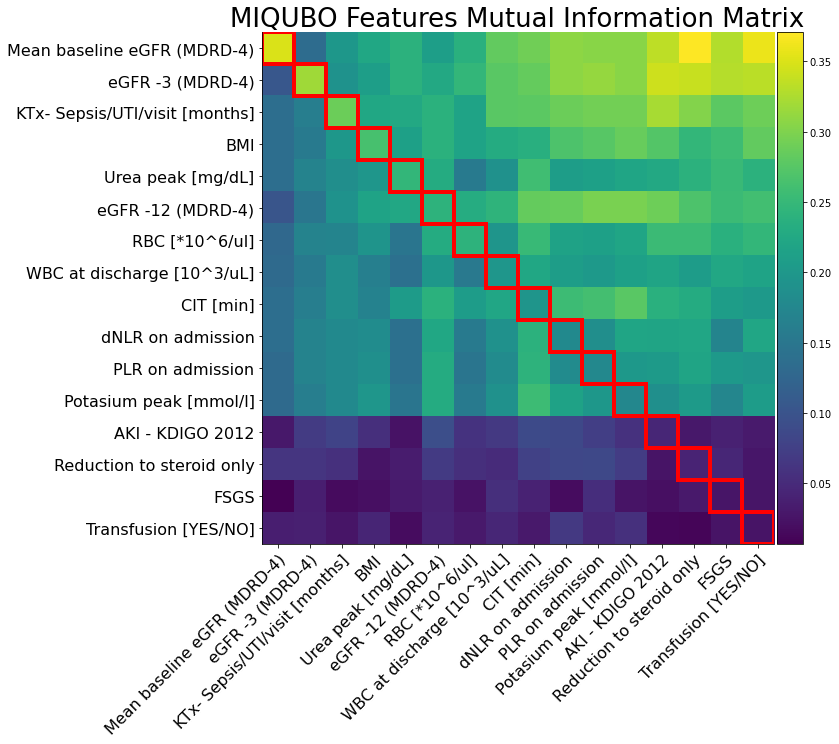

In [17]:

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def plot_mi_matrix(df, target_f, f_map, rev_map):
    mi_matrix=get_mi_matrix(df, target_f)
    features = list(map(lambda x: x[0], sorted({rev_map[x] : mutual_information(prob(df_miqubo[[target_f, x]].values), 1) for x in df_miqubo.columns if x!=target_f}.items(), key = lambda x: x[1], reverse = True)))
    pd.DataFrame(data=mi_matrix, index=features, columns=features).to_csv("models_evaluation/mi_matrix/miqubo_mi_matrix.csv")
    x = np.arange(len(features))
    y = np.arange(len(features))
    fig, ax = plt.subplots(figsize=(12, 12))
    #cmap = 'jet'
    im = ax.imshow(mi_matrix, )#cmap="cool")
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title("MIQUBO Features Mutual Information Matrix", fontsize=26)
    ax.set_xticks(x)
    #ax.set_xlabel(label_x, fontsize=18)
    ax.set_yticks(x)
    #ax.set_ylabel(label_y, fontsize=18, rotation = -90)
    ax.set_xticklabels(features, fontsize=16)
    ax.set_yticklabels(features, fontsize=16)
    ax.xaxis.set_label_position("top")
    ax.yaxis.set_label_position("right")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    #plt.imshow(mi_matrix)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    for i in np.arange(len(features)):
        highlight_cell(i,i, ax, color="red", linewidth=4)
    
    plt.savefig("plots/mi_matrix/MIQBO_MI_matrix.png", bbox_inches='tight')
    plt.show()


plot_mi_matrix(df_miqubo, target_f, naming_map_for_plots, rev_map)

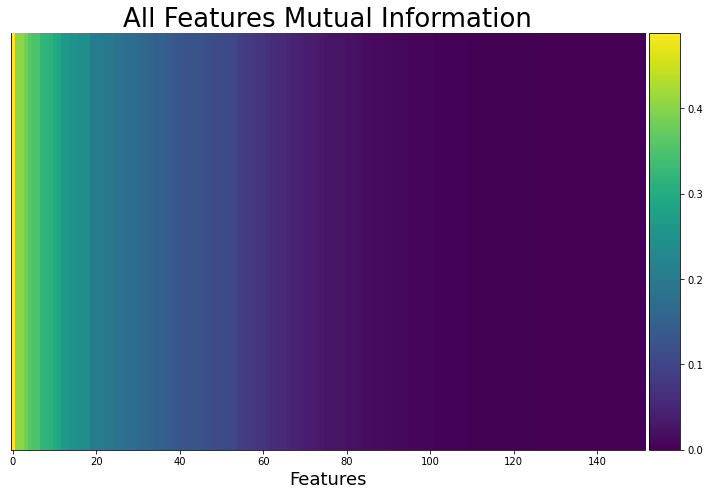

In [45]:
all_f_mi = list(map(lambda x: x[1], sorted({x : mutual_information(prob(df_all[[target_f, x]].values), 1) for x in df_all.columns}.items(), key = lambda x: x[1], reverse = True)))
h_size = 100
all_mi = []
for r in range(h_size):
    all_mi.append(all_f_mi)

fig, ax = plt.subplots(figsize=(12, 24))
#cmap = 'jet'
im = ax.imshow(all_mi, )#cmap="cool")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("All Features Mutual Information", fontsize=26)
#ax.set_xticks(x)
ax.set_xlabel("Features", fontsize=18)
ax.set_yticks([])
#ax.set_ylabel(label_y, fontsize=18, rotation = -90)
#ax.set_xticklabels(labels, fontsize=16)
#ax.set_yticklabels(labels, fontsize=16)
ax.xaxis.set_label_position("bottom")
ax.yaxis.set_label_position("right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.savefig("plots/mi_matrix/ALL_MI.png", bbox_inches='tight')

plt.show()